<a href="https://colab.research.google.com/github/LuanPCunha/TCC/blob/main/Treinamento_ShallowNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rotinas de Treinamento


## Configurações Iniciais 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import string, re
import itertools
import nltk
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import EarlyStopping
py.init_notebook_mode(connected=True)
%matplotlib inline
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

## Lendo a Base

In [3]:
# Base1 Com StopWords
PATH_BASE1 = "/content/drive/MyDrive/TCC/dados/processadas/Base1_classificada.csv"

# Base2 Sem StopWords
PATH_BASE2 = "/content/drive/MyDrive/TCC/dados/processadas/Base2_classificada.csv"

# Base1 Com StopWords
PATH_BASE1_JUNTO_COM_DA_LEILA = "/content/drive/MyDrive/TCC/dados/processadas/Base1JuntaHateENotHateDaLeila.csv"

# Base2 Sem StopWords
PATH_BASE2_LEILA_LIMPISSIMA = "/content/drive/MyDrive/TCC/dados/processadas/Base2_maior4_menor25_limpissima.csv"

In [4]:
#trainDF = pd.read_csv(PATH_BASE2_LEILA_LIMPISSIMA, index_col=0)
trainDF = pd.read_csv(PATH_BASE2_LEILA_LIMPISSIMA)

In [5]:
# Agrupa dados por label
trainDF.groupby('label').count()

,text
label,
hate,2443
not_hate,19282


In [6]:
categorias_desejadas = ['hate', 'not_hate'] # !!!
df_filtrado = trainDF[trainDF.label.isin(categorias_desejadas)]
df_filtrado.shape

(21725, 2)

In [7]:
df_filtrado

,label,text
0,not_hate,geral foi no jogo do foz
1,not_hate,pois é não é gente é isso ai pessoal
2,not_hate,ontem eu estava tão mal que escrevi tudo o que...
3,not_hate,eu devo ter um coração de pedra não sou de me ...
4,not_hate,camimq vivobr pois é estou tentando entender
...,...,...
21720,hate,eduguim depois falam que nordestino não sabe ...
21721,hate,e dizem por aí que o nordestino não sabe votar
21722,hate,ain que nordestino não sabe votar e blá blá blá
21723,hate,imagine essa turma da extrema direita soltando...


In [8]:
def balanceia_dados(df, verbose=0):
    # Esta funcao recebe um dataframe original e retorna um dataset
    # contendo um numero igual de noticias das categorias
    # por simplicidade, vou supor que são somente duas categorias.
    global categorias_desejadas
    df_balanceado = df.copy()
    
    # cria um dataframe para cada classe. Assim podemos remover o excesso
    df_F = df_balanceado.loc[df_balanceado.label == categorias_desejadas[0]]
    df_T = df_balanceado.loc[df_balanceado.label == categorias_desejadas[1]]

    num_amostras_F, num_amostras_T = df_F.shape[0], df_T.shape[0]
    num_amostras_a_remover = abs(num_amostras_F - num_amostras_T)
    
    # remove amostras da classe majoritaria
    if num_amostras_F > num_amostras_T:
        #print(df_F[:num_amostras_a_remover)
        df_F = df_F[num_amostras_a_remover:]
        
    elif num_amostras_T > num_amostras_F:
        #
        df_T = df_T[num_amostras_a_remover:]

    return pd.concat([df_F, df_T])

In [9]:
# Aplica função de balancear os dados
dataBC = balanceia_dados(df_filtrado)

# DATA BALANCEADO
trainDF = dataBC
trainDF.reset_index(drop=True, inplace=True) # reseta index
trainDF.shape

(4886, 2)

In [10]:
# convert output  hate =1 not_hate =0
trainDF.label = [1 if each == "hate" else 0 for each in trainDF.label] 

In [11]:
trainDF.groupby('label').count()

,text
label,
0,2443
1,2443


In [12]:
# Pega a média de caracteres dos tweets de toda a base
average_len = int(trainDF['text'].apply(lambda x: len(str(x))).mean())
average_len

62

In [13]:
quantidade_palavras_unicas = len( list ( trainDF['text'].str.split(' ', expand=True).stack().unique() ) )
quantidade_palavras_unicas

9144

## ShallowNet

In [14]:
# Salva os registros da coluna 'text' do dataframe em uma lista
text = []
trainDF['text'].apply(lambda x: text.append(x))
print(text)

['ambiguinho eu estou com nojo', 'menino do céu para que está feio', 'já pergunto a porra do trem já sabendo da vdd e a pessoa mente ainda me poupe', 'sardella só faz merda', 'foda se na real vou tratar igual', 'putasso com essa merda', 'o filho da puta do estagiário 30 minutos para mexer no time', 'a prof de artes é muito filho da puta velho puta que pariu', 'uma vida baseada em mentiras eu quero se foda', 'lana coimbra é foda te entendo porque estou na mesma', 'da vontade de trancar essa porra e tentar com outra turma', 'isa cantagalli não faz merda que eu sou brava', 'devo ter sido grossa para caralho mas acho que foi necessário', 'vim para academia e esqueci a porra do meu cartão só porque queria comprar umas cervejas', 'perderam a porra do joga agora vai me perturbar', 'xico graziano querem comer o que no futuro merda', 'por isso que eu ja disse milhões de vzes  patrick eu te odeio seu desgraçado', 'toma no cú gustavin está metendo gol pcrl né viado', 'meu emocional e um lixo', 'e

In [24]:
# Para que transformar os tuítes em matriz de números
tokenizer = Tokenizer(num_words=5000, split=' ')

tokenizer.fit_on_texts(text)
X = tokenizer.texts_to_sequences(text)  

# limitando o tamanho das sequências com base no tamanho máximo que especificamos na variável "max_sequence_length"
X = pad_sequences(X, maxlen=average_len)

In [25]:
Y = trainDF['label']

In [26]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X, Y, test_size=0.3, random_state=2)

In [46]:
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(1000, activation="softmax")(input_layer)
     
    # create output layer
    output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)

    classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    
    return classifier 

# Modelo criado
model = create_model_architecture(train_x.shape[1])

# Modelo sendo treinado/executado
epochs = 1000
batch_size = 64
hist = model.fit(
      train_x, 
      train_y, 
      validation_data=(valid_x, valid_y),
      epochs=epochs,
      batch_size=batch_size, 
      shuffle=True,
      verbose=1)

model.save_weights("teste")    



Epoch 1/1000
54/54 [==============================] - 2s 20ms/step - loss: 0.6892 - accuracy: 0.5687 - val_loss: 0.6875 - val_accuracy: 0.5866
Epoch 2/1000
54/54 [==============================] - 0s 9ms/step - loss: 0.6827 - accuracy: 0.6322 - val_loss: 0.6832 - val_accuracy: 0.6173
Epoch 3/1000
54/54 [==============================] - 0s 5ms/step - loss: 0.6796 - accuracy: 0.6216 - val_loss: 0.6823 - val_accuracy: 0.5812
Epoch 4/1000
54/54 [==============================] - 0s 5ms/step - loss: 0.6744 - accuracy: 0.6383 - val_loss: 0.6804 - val_accuracy: 0.5880
Epoch 5/1000
54/54 [==============================] - 0s 5ms/step - loss: 0.6732 - accuracy: 0.6263 - val_loss: 0.6782 - val_accuracy: 0.5962
Epoch 6/1000
54/54 [==============================] - 0s 4ms/step - loss: 0.6715 - accuracy: 0.6257 - val_loss: 0.6772 - val_accuracy: 0.5955
Epoch 7/1000
54/54 [==============================] - 0s 5ms/step - loss: 0.6689 - accuracy: 0.6281 - val_loss: 0.6741 - val_accuracy: 0.5935
Epoch

In [37]:
# print(type(hist.history))
# print(hist.history.keys())
# print(hist.history)

<class 'dict'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
{'loss': [0.6886511445045471, 0.6824889779090881, 0.6776125431060791, 0.6750727295875549, 0.673039436340332, 0.6718489527702332, 0.6705769300460815, 0.6680951714515686, 0.6666166186332703, 0.6601746678352356, 0.6579859852790833, 0.6593432426452637, 0.6564946174621582, 0.655145525932312, 0.6531596779823303, 0.6513797044754028, 0.6492760181427002, 0.651860773563385, 0.6535083651542664, 0.6529121398925781], 'accuracy': [0.5795321464538574, 0.6283625960350037, 0.6383041143417358, 0.6236842274665833, 0.6178362369537354, 0.6175438761711121, 0.613450288772583, 0.6166666746139526, 0.6078947186470032, 0.6239765882492065, 0.6271929740905762, 0.6169590353965759, 0.624853789806366, 0.621052622795105, 0.6274853944778442, 0.6333333253860474, 0.6368421316146851, 0.6236842274665833, 0.621345043182373, 0.6187134385108948], 'val_loss': [0.685002863407135, 0.6829689741134644, 0.6826983094215393, 0.6786336898803711, 0.6764301657676

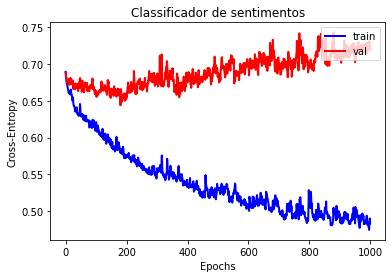

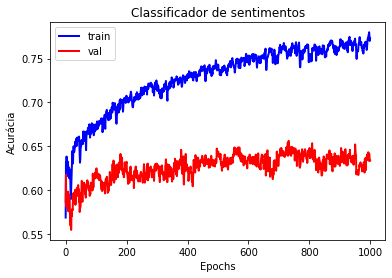

In [47]:
# Plot
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('Classificador de sentimentos')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend(loc='upper right')
plt.show()

plt.figure()
plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('Classificador de sentimentos')
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend(loc='upper left')
plt.show()